# CDR exploration of a telco company

In [1]:
#!pip freeze --user > requirements.txt
#!while read p; do pip install --user "${p}" --ignore-installed ; done <./requirements.txt

### About the data set

This dataset provides information about the telecommunication activity over the city of Milano.

The dataset is the result of a computation over the Call Detail Records (CDRs) generated by a telco company cellular network over the city of Milano. CDRs log the user activity for billing purposes and network management. There are many types of CDRs, for the generation of this dataset we considered those related to the following activities:

    - Received SMS: a CDR is generated each time a user receives an SMS
    - Sent SMS: a CDR is generated each time a user sends an SMS
    - Incoming Calls: a CDR is generated each time a user receives a call
    - Outgoing Calls: CDR is generated each time a user issues a call
    - Internet: a CDR is generate each time
        - a user starts an internet connection
        - a user ends an internet connection
        - during the same connection one of the following limits is reached:​
            - 15 minutes from the last generated CDR
            - 5 MB from the last generated CDR

By aggregating the aforementioned records it was created this dataset that provides SMSs, calls and Internet traffic activity. It measures the level of interaction of the users with the mobile phone network; for example the higher is the number of SMS sent by the users, the higher is the activity of the sent SMS. Measurements of call and SMS activity have the same scale (therefore are comparable); those referring to Internet traffic do not. 

On the dataset, the activities are referenced by a position on a grid.

![grid structure](https://dandelion.eu/media/uploads/images/Milano_GRID_4326.png)

WGS84 (EPSG:4326)
    - [x1,y1] = [ 9.011533669936474, 45.56821407553667 ]
    - [x2,y2] = [ 9.312688264185276, 45.56778671132765 ]
    - [x3,y3] = [ 9.311521155996243, 45.356261753717845 ]  
    - [x4,y4] = [ 9.011490619692509, 45.356685994655464 ]
    - d: 235 m

As previously shown squares are numbered with ids. The square id numbering starts from the bottom left corner of the grid and grows till its right top corner.

In the following picture the grid is overlaid to the city of Milan city.

![milano grid](https://dandelion.eu/media/uploads/images/milano-grid-img2.jpg)

### Libraries importing

In [2]:
import pyspark.sql.functions as func
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#!pip install <library>

### Credentials for accessing files in Object Storage

In [4]:
# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_aa816606(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '37ef207335594d13ab057421343b750e')
    hconf.set(prefix + '.username', '64554628f07e4ee2ad45558ff6d578f7')
    hconf.set(prefix + '.password', 'Z}1)*2Acz==c,zgZ')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_aa816606(name)

spark = SparkSession.builder.getOrCreate()

### Reading the main data set file with network activity info

In [5]:
telco_data_full = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://TelefonicaCHI.' + name + '/sms-call-internet-mi-2013-12-01.csv')\
  .fillna('0')\
  .cache()

### Sampling DataFrame

In [6]:
telco_data_full.show(5)

+--------+-------------+-------+--------------------+-------------------+--------------------+-------------------+--------------------+
|squareId|     interval|country|               SMSin|             SMSout|              CallIn|            CallOut|     InternetTraffic|
+--------+-------------+-------+--------------------+-------------------+--------------------+-------------------+--------------------+
|       1|1385852400000|     39| 0.11098916961424417|0.16621436886121638| 0.10920185950874473|0.16442705875571695|  13.648437920592805|
|       1|1385852400000|     46|                   0|                  0|                   0|                  0|0.026137424264286602|
|       1|1385853000000|     39| 0.16513682662061693| 0.1763994583739133|0.030875085088185057|0.02730046487718618|  13.330858194494864|
|       1|1385853600000|      0|0.029087774982685617|0.02730046487718618|                   0|                  0|                   0|
|       1|1385853600000|     39| 0.1864510916887

In [7]:
telco_data_full.count()

4438331

### Manipulating DataFrame

In [8]:
telco_data_full_temp = telco_data_full.withColumn("SMSin", telco_data_full["SMSin"].cast("double"))\
    .withColumn("SMSout", telco_data_full["SMSout"].cast("double"))\
    .withColumn("CallIn", telco_data_full["CallIn"].cast("double"))\
    .withColumn("CallOut", telco_data_full["CallOut"].cast("double"))\
    .withColumn("InternetTraffic", telco_data_full["InternetTraffic"].cast("double"))

### Grouping by activity type

In [9]:
telco_data_full_count = telco_data_full_temp.groupBy().sum('CallIn','CallOut','SMSin','SMSout','InternetTraffic')\
    .withColumnRenamed("SUM(CallIn)", "CallIn")\
    .withColumnRenamed("SUM(CallOut)", "CallOut")\
    .withColumnRenamed("SUM(SMSin)", "SMSin")\
    .withColumnRenamed("SUM(SMSout)", "SMSout")\
    .withColumnRenamed("SUM(InternetTraffic)", "InternetTraffic")

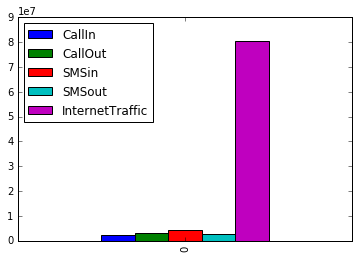

In [10]:
telco_data_full_count.toPandas().plot.bar()

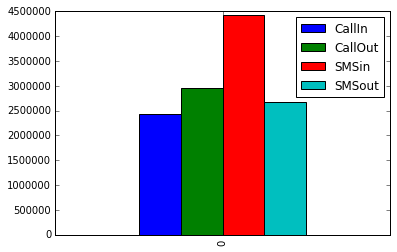

In [11]:
telco_data_full_count.select('CallIn','CallOut','SMSin','SMSout').toPandas().plot.bar()

### Reading the file with the list of countries and its codes

In [12]:
country_codes = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://TelefonicaCHI.' + name + '/country-codes-small.csv')\
  .cache()

In [13]:
country_codes.show(5)

+-------------+----+
|         name|Dial|
+-------------+----+
|United States|   1|
|       Russia|   7|
|        Egypt|  20|
| South Africa|  27|
|       Greece|  30|
+-------------+----+
only showing top 5 rows



### Counting how many activities happened from/to Italy to/from each country

In [14]:
dfCountActCountry = telco_data_full.groupBy("country").count().orderBy("count",ascending=False)

In [15]:
dfCountActCountry.show(5)

+-------+-------+
|country|  count|
+-------+-------+
|     39|1439320|
|      0|1058160|
|     49| 166877|
|     46| 157819|
|     33| 147041|
+-------+-------+
only showing top 5 rows



### Joining the two files to translate country code to country name

In [16]:
dfCountryCodeTranslated = dfCountActCountry.join(country_codes, dfCountActCountry.country == country_codes.Dial).select("country", "name", "count")

In [17]:
dfCountryCodeTranslated.show(5)

+-------+-------+-------+
|country|   name|  count|
+-------+-------+-------+
|     39|  Italy|1439320|
|     49|Germany| 166877|
|     46| Sweden| 157819|
|     33| France| 147041|
|     20|  Egypt| 144565|
+-------+-------+-------+
only showing top 5 rows



### Checking the countries with more interactions with Italy using Pixiedust

In [18]:
import pixiedust

Pixiedust database opened successfully


In [19]:
#!pip install --user --upgrade pixiedust

In [20]:
dfCountryCodeTranslatedSmall = dfCountryCodeTranslated.orderBy("count", ascending=False).where("name != 'Italy'").limit(15)

In [21]:
display(dfCountryCodeTranslatedSmall)

### Creating heat map based on the number of activity for each sector of the grid

### Creating a vector with grid sector ids

In [22]:
sectors = spark.createDataFrame(range(1, 10001), IntegerType())

In [23]:
activity_count_by_sector = telco_data_full\
    .groupBy("squareId")\
    .count()\
    .orderBy("squareId", ascending=False)

In [24]:
df_heat = sectors\
    .join(activity_count_by_sector, sectors.value == activity_count_by_sector.squareId, 'left')\
    .fillna(0.0)\
    .select('value', 'count')\
    .orderBy('value')

In [25]:
heat_count_list = df_heat.select("count").rdd.flatMap(lambda x: x).collect()

In [26]:
heat_count_list_splitted = np.array_split(heat_count_list, 100)
heat_count_list_splitted.reverse()

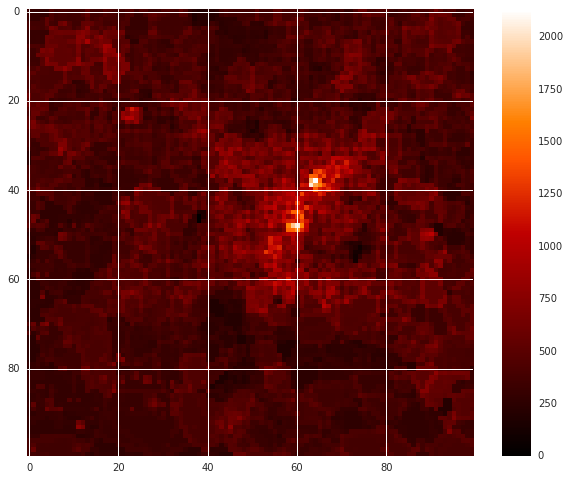

In [27]:
fig, ax = plt.subplots()
cax = fig.add_axes([0.95, 0.125, 0.05, 0.775])

im = ax.imshow(heat_count_list_splitted, cmap='gist_heat', interpolation='nearest')
fig.colorbar(im, cax=cax, orientation='vertical')
fig.set_size_inches(8,8)
plt.show()

### Making connection of the heat map with the map of the city of Milan

In [28]:
sectors_geoloc = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://TelefonicaCHI.' + name + '/milano-grid.csv')
sectors_geoloc.show(5)

+--------+---------+--------+
|squareId|      lat|     lon|
+--------+---------+--------+
|       1|45.357743|9.012991|
|       2|45.357743|9.015991|
|       3|45.357743|9.018992|
|       4|45.357743|9.021992|
|       5|45.357743|9.024993|
+--------+---------+--------+
only showing top 5 rows



In [29]:
sectors_geoloc_tmp = sectors_geoloc.withColumnRenamed("squareId", "squareId_2")

In [30]:
df_heat_folium_tmp = sectors_geoloc_tmp\
    .join(activity_count_by_sector, sectors_geoloc_tmp.squareId_2 == activity_count_by_sector.squareId, 'left')\
    .fillna(0.0)

In [31]:
df_heat_folium = df_heat_folium_tmp.select('*').orderBy('count', ascending=False).limit(150).toPandas()

In [32]:
df_heat_folium.head(5)

,squareId_2,lat,lon,squareId,count
0,6165,45.486776,9.205018,6165,2130
1,5161,45.465623,9.193016,5161,2041
2,6064,45.484660,9.202017,6064,2041
3,5160,45.465623,9.190016,5160,1890
4,6164,45.486776,9.202017,6164,1824


In [33]:
lats = [float(item) for item in df_heat_folium.lat]
lons = [float(item) for item in df_heat_folium.lon]
mag = [float(item) for item in df_heat_folium['count']]

In [34]:
import folium
from folium import plugins

schools_heatmap = folium.Map(location=[45.465033, 9.186578], zoom_start=12)
schools_heatmap.add_child(plugins.HeatMap(zip(lats, lons, mag), radius = 9))
schools_heatmap